# Coseismic Landslide Probability Modeling
**Brek Chiles, 2022**

### Purpose
This notebook calculates coseismic landslide probability by implementing the Nowicki Jessee et al. (2018) model. My technical report provides instructions for creating the required input parameters in the methods section. Although my project focuses on the Lower Bogachiel River Valley and M9 Cascadia Subduction Zone earthquakes, calculations for coseismic landslide probability in other study areas are achievable by modifying the Python code in this notebook and GitHub repository.

In [1]:
## Import modules
import os
import numpy as np
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
## Set file paths
brv_dem = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\BRV_DEM_m.tif'
brv_slope = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\BRV_Slope.tif'
brv_cti = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\BRV_CTI.tif'
brv_lulc = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\BRV_LULC_Reclass.tif'
brv_litho = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\BRV_Lithology.tif'

## Calculate the topograhic slope input with gdaldem slope
Check the file path of the slope output

In [3]:
## Use gdaldem to calculate slope from a DEM
!gdaldem slope $brv_dem $brv_slope

0...10...20...30...40...50...60...70...80...90...100 - done.


In [4]:
## Create Rasterio arrays for the DEM and slope map
brv_dem_rio = rio.open(brv_dem)
brv_dem_rio_array = brv_dem_rio.read(1, masked=True)
brv_slope_rio = rio.open(brv_slope)
brv_slope_rio_array = brv_slope_rio.read(1, masked=True)

Create a plot showing the DEM and slope map

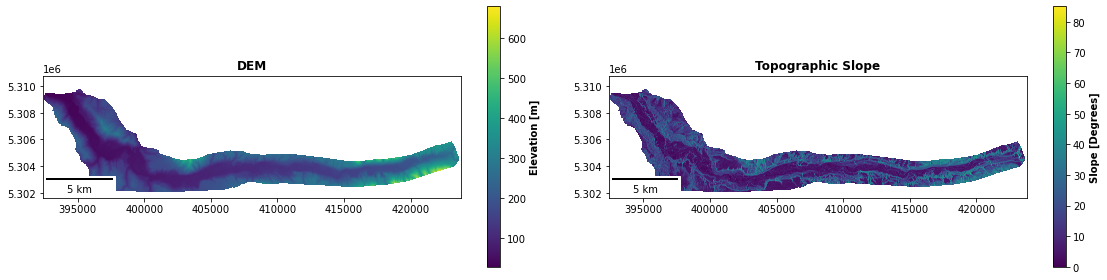

In [5]:
## Get the plotting extent
plt_extent = rio.plot.plotting_extent(brv_slope_rio)

## Subplots
f, ax = plt.subplots(1,2, figsize=(16, 4))
# DEM
dem_plot = ax[0].imshow(brv_dem_rio_array, cmap='viridis', extent=plt_extent);
ax[0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0].set_title('DEM', fontweight='bold')
dem_cbar = f.colorbar(dem_plot, ax=ax[0]);
dem_cbar.set_label('Elevation [m]', fontweight='bold')
# Slope
slope_plot = ax[1].imshow(brv_slope_rio_array, cmap='viridis', extent=plt_extent);
ax[1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1].set_title('Topographic Slope', fontweight='bold')
slope_cbar = f.colorbar(slope_plot, ax=ax[1]);
slope_cbar.set_label('Slope [Degrees]', fontweight='bold')

plt.tight_layout()

## Create a Rasterio array for CTI

In [6]:
## Check the file path of the CTI input
brv_cti_rio = rio.open(brv_cti)
brv_cti_rio_array = brv_cti_rio.read(1, masked=True)

Create a plot for CTI

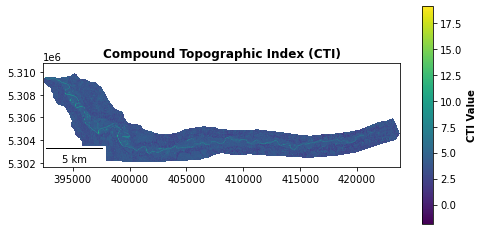

In [7]:
## Subplot
f, ax = plt.subplots(figsize=(8, 4))
# CTI
cti_plot = ax.imshow(brv_cti_rio_array, cmap='viridis', extent=plt_extent);
ax.add_artist(ScaleBar(1.0, location="lower left"))
ax.set_title('Compound Topographic Index (CTI)', fontweight='bold')
cti_cbar = f.colorbar(cti_plot, ax=ax);
cti_cbar.set_label('CTI Value', fontweight='bold')

## Reclassify Land Cover
Land cover types and the associated class values and regression coefficients are available in Table 3 by Nowicki Jessee et al. (2018). The table below provides the land cover classifications for reference. Although my land cover dataset does not use all land cover types, I included all reclassifications in case anyone implements this notebook for study areas with other land cover classifications.

| Land Cover Type | Class Value | Regression Coefficient |
| :---: | :---: | :---: |
| Rainfed croplands | 14 | 0.91 |
| Mosaic cropland | 20 | 0.88 |
| Mosaic vegetation | 30 | 0.78 |
| Closed to open broadleaved evergreen or semideciduous forest | 40 | 0.68 |
| Closed broadleaved deciduous forest | 50 | 0.30 |
| Rainfed croplands | 60 | 1.77 |
| Closed needleleaved evergreen forest | 70 | 1.71 |
| Open needleleaved deciduous or evergreen forest | 90 | -1.26 |
| Closed to open mixed broadleaved and needleleaved forest | 100 | 1.50 |
| Mosaic forest or shrubland/grassland | 110 | 0.68 |
| Mosaic grassland/forest or shrubland | 120 | 1.13 |
| Closed to open broadleaved or needleleaved, evergreen or deciduous  | 130 | 0.79 |
| Closed to open herabceous vegetation | 140 | 1.03 |
| Sparse vegetation | 150 | 0.54 |
| Closed to open broadleaved forest regulary flooded | 160 | 2.34 |
| Closed to open grassland or woody vegetation on regularly flooded or waterlogged, soil, fresh, brackish, or saline water | 180 | 1.19 |
| Artificial surfaces and associated areas | 190 | 0.30 |
| Bare areas | 200 | -0.06 |
| Water Bodies | 210 | NaN |
| Permanent snow and ice | 220 | -0.18 |
| No data | 230 | -1.08 |

In [8]:
## Create a Rasterio array for the land cover input
brv_lulc_rio = rio.open(brv_lulc)
brv_lulc_rio_class = brv_lulc_rio.read(1, masked=True)

## Make the integer values floats before reclassifying
brv_lulc_copy = brv_lulc_rio_class.copy()
brv_lulc_flt = np.asarray(brv_lulc_copy, dtype=float, order='C') 

## Use np.where to reclassify class values to regression coefficients
brv_lulc_flt[np.where(brv_lulc_flt == 14.)] = 0.91 
brv_lulc_flt[np.where(brv_lulc_flt == 20.)] = 0.88 
brv_lulc_flt[np.where(brv_lulc_flt == 30.)] = 0.78 
brv_lulc_flt[np.where(brv_lulc_flt == 40.)] = 0.68 
brv_lulc_flt[np.where(brv_lulc_flt == 50.)] = 0.30 
brv_lulc_flt[np.where(brv_lulc_flt == 60.)] = 1.77
brv_lulc_flt[np.where(brv_lulc_flt == 70.)] = 1.71 
brv_lulc_flt[np.where(brv_lulc_flt == 90.)] = -1.26 
brv_lulc_flt[np.where(brv_lulc_flt == 100.)] = 1.50 
brv_lulc_flt[np.where(brv_lulc_flt == 110.)] = 0.68 
brv_lulc_flt[np.where(brv_lulc_flt == 120.)] = 1.13 
brv_lulc_flt[np.where(brv_lulc_flt == 130.)] = 0.79 
brv_lulc_flt[np.where(brv_lulc_flt == 140.)] = 1.03 
brv_lulc_flt[np.where(brv_lulc_flt == 150.)] = 0.54 
brv_lulc_flt[np.where(brv_lulc_flt == 160.)] = 2.34
brv_lulc_flt[np.where(brv_lulc_flt == 180.)] = 1.19  
brv_lulc_flt[np.where(brv_lulc_flt == 190.)] = 0.30  
brv_lulc_flt[np.where(brv_lulc_flt == 200.)] = -0.06 
brv_lulc_flt[np.where(brv_lulc_flt == 210.)] = np.nan
brv_lulc_flt[np.where(brv_lulc_flt == 220.)] = -0.18  
brv_lulc_flt[np.where(brv_lulc_flt == 230.)] = -1.08

In [9]:
## Save the reclassified land cover to a GeoTIFF
lulc_reclass_fp = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\BRV_LULC_Coeff.tif'
brv_lulc_rio_profile = brv_lulc_rio.profile
brv_lulc_rio_profile.update(dtype=rio.float64)
if not os.path.exists(lulc_reclass_fp):
    with rio.open(lulc_reclass_fp, "w", **brv_lulc_rio_profile) as dst:
        dst.write(brv_lulc_flt, 1)

Create plots for land cover class values and regression coefficients

In [10]:
## Create a Rasterio array for the land cover regression coefficients
brv_lulc_rg = rio.open(lulc_reclass_fp)
brv_lulc_rio_rg = brv_lulc_rg.read(1, masked=True) 

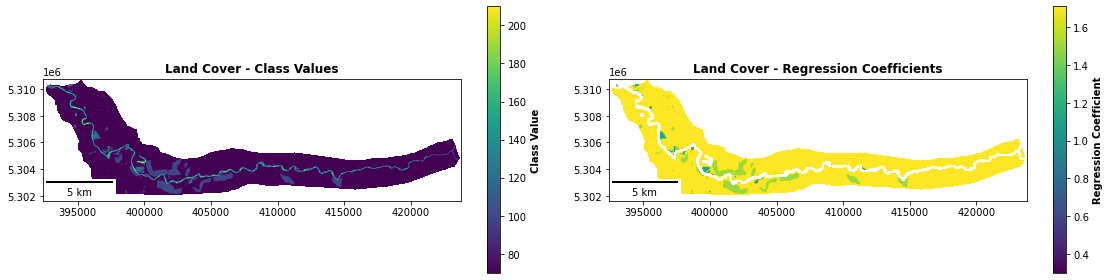

In [11]:
## Subplots
f, ax = plt.subplots(1,2, figsize=(16, 4))
# Land cover class values
lulc_cv_plot = ax[0].imshow(brv_lulc_rio_class, cmap='viridis', extent=plt_extent);
ax[0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0].set_title('Land Cover - Class Values', fontweight='bold')
lulc_cv_cbar = f.colorbar(lulc_cv_plot, ax=ax[0]);
lulc_cv_cbar.set_label('Class Value', fontweight='bold')
# Land cover regression coefficients
lulc_rg_plot = ax[1].imshow(brv_lulc_rio_rg, cmap='viridis', extent=plt_extent);
ax[1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1].set_title('Land Cover - Regression Coefficients', fontweight='bold')
lulc_rg_cbar = f.colorbar(lulc_rg_plot, ax=ax[1]);
lulc_rg_cbar.set_label('Regression Coefficient', fontweight='bold')

plt.tight_layout()

## Reclassify Lithology
Lithologies are available in Table 3 by Nowicki Jessee et al. (2018). The table below provides the lithology classifications for reference.

| Lithology Type | Class Value | Regression Coefficient |
| :---: | :---: | :---: |
| Intermediate Volcanic Rock | 1 | -0.81 |
| Basic Volcanic Rocks | 2 | -1.50 |
| Acid Plutonic Rocks | 3 | -0.78 |
| Metamorphic Rocks | 4 | -1.87 |
| Unconsolidated Sediments | 5 | -3.22 |
| Siliciclastic Sedimentary Rocks | 6 | -1.92 |
| Basic Plutonic Rocks | 7 | -1.88 |
| Intermediate Plutonic Rocks | 8 | -1.61 |
| Mixed Sedimentary Rocks | 9 | -1.36 |
| Water Bodies | 10 | NaN |
| Pyroclastics | 11 | -1.05 |
| Carbonate Sedimentary Rocks  | 12 | -0.95 |
| Acid Volcanic Rocks | 13 | -1.54 |
| No Data | 14 | -0.66 |
| Evaporites | 15 | NaN |

In [12]:
## Create a Rasterio array for the lithology input
brv_litho_rio = rio.open(brv_litho)
brv_litho_rio_class = brv_litho_rio.read(1, masked=True)

## Make the integer values floats before reclassifying
brv_litho_copy = brv_litho_rio_class.copy()
brv_litho_flt = np.asarray(brv_litho_copy, dtype=float, order='C')

## Use np.where to reclassify class values to regression coefficients
brv_litho_flt[np.where(brv_litho_flt == 1.)] = -0.81
brv_litho_flt[np.where(brv_litho_flt == 2.)] = -1.5 
brv_litho_flt[np.where(brv_litho_flt == 3.)] = -0.78 
brv_litho_flt[np.where(brv_litho_flt == 4.)] = -1.87 
brv_litho_flt[np.where(brv_litho_flt == 5.)] = -3.22 
brv_litho_flt[np.where(brv_litho_flt == 6.)] = -1.92 
brv_litho_flt[np.where(brv_litho_flt == 7.)] = -1.88 
brv_litho_flt[np.where(brv_litho_flt == 8.)] = -1.61 
brv_litho_flt[np.where(brv_litho_flt == 9.)] = -1.36 
brv_litho_flt[np.where(brv_litho_flt == 10.)] = np.nan 
brv_litho_flt[np.where(brv_litho_flt == 11.)] = -1.05 
brv_litho_flt[np.where(brv_litho_flt == 12.)] = -0.95 
brv_litho_flt[np.where(brv_litho_flt == 13.)] = -1.54 
brv_litho_flt[np.where(brv_litho_flt == 14.)] = -0.66
brv_litho_flt[np.where(brv_litho_flt == 15.)] = np.nan

In [13]:
## Save the reclassified lithology to a GeoTIFF
litho_reclass_fp = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\BRV_Litho_Coeff.tif'
brv_litho_rio_profile = brv_litho_rio.profile
brv_litho_rio_profile.update(dtype=rio.float64)
if not os.path.exists(litho_reclass_fp):
    with rio.open(litho_reclass_fp, "w", **brv_litho_rio_profile) as dst:
        dst.write(brv_litho_flt, 1)

Create plots for lithology class values and regression coefficients

In [14]:
## Create a Rasterio array for the lithology regression coefficients
brv_litho_rg = rio.open(litho_reclass_fp)
brv_litho_rio_rg = brv_litho_rg.read(1, masked=True) 

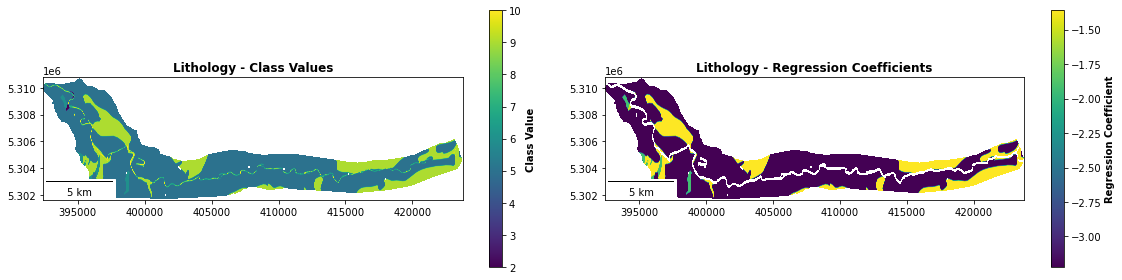

In [15]:
## Subplots
f, ax = plt.subplots(1,2, figsize=(16, 4))
# Lithology class values
litho_cv_plot = ax[0].imshow(brv_litho_rio_class, cmap='viridis', extent=plt_extent);
ax[0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0].set_title('Lithology - Class Values', fontweight='bold')
litho_cv_cbar = f.colorbar(litho_cv_plot, ax=ax[0]);
litho_cv_cbar.set_label('Class Value', fontweight='bold')
# Lithology regression coefficients
litho_rg_plot = ax[1].imshow(brv_litho_rio_rg, cmap='viridis', extent=plt_extent);
ax[1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1].set_title('Lithology - Regression Coefficients', fontweight='bold')
litho_rg_cbar = f.colorbar(litho_rg_plot, ax=ax[1]);
litho_rg_cbar.set_label('Regression Coefficient', fontweight='bold')

plt.tight_layout()

## Calculate Coseismic Landslide Probability
The following code cells will resample topographic slope, CTI, land cover, and lithology to the resolution of the PGV input. Coseismic landslide probability is calculated with equations 3 and 8 from Nowicki Jessee et al. (2018).  

**Equation 3**
$$P(t) = \frac{1}{1+e^{-t}}$$

**Equation 8**
$$t = a+b\times{ln(PGV)}+c\times{Slope}+d\times{Lithology}+e\times{\text{Land Cover}}+f\times{CTI}+g\times{ln(PGV)}\times{Slope}$$

**Peak Ground Velocity (PGV)**

In [16]:
## Before resampleing the resolution of each input, extract the cellsize of the PGV input
pgv_model_fp = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\CSZ_M9_100m_clip\csz002_100m_clip.tif'
pgv_model_rio = rio.open(pgv_model_fp)

## Create a Rasterio array for PGV
pgv_rio_array = pgv_model_rio.read(1, masked=True)

## Get cellsize from the transform
metdata = pgv_model_rio.transform
cellsize = int(metdata[0])
cellsize

100

In [17]:
## Extract extent values for gdalwarp and plotting 
pgv_extent = rio.plot.plotting_extent(pgv_model_rio)
# (left, right, bottom, top)
pgv_extent

(392400.9631, 423800.9631, 5301955.3274, 5309955.3274)

In [18]:
## Variables for gdalwarp
min_x = pgv_extent[0]
min_y = pgv_extent[2]
max_x = pgv_extent[1]
max_y = pgv_extent[3]

**Topographic Slope**

In [19]:
## Resample topographic slope
output_crs = 'EPSG:32610'
brv_slope_resample = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\Resampled\BRV_Slope_100m.tif'
if not os.path.exists(brv_slope_resample):
    !gdalwarp -r bilinear -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te $min_x $min_y $max_x $max_y -te_srs $output_crs -tr $cellsize $cellsize $brv_slope $brv_slope_resample

In [20]:
## Create a Rasterio array for resampled topographic slope
brv_slope_resample_rio = rio.open(brv_slope_resample)
slope_warp_array = brv_slope_resample_rio.read(1, masked=True)

**Compound Topographic Index (CTI)**

In [21]:
## Resample CTI
brv_cti_resample = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\Resampled\BRV_CTI_100m.tif'
if not os.path.exists(brv_cti_resample):
    !gdalwarp -r bilinear -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te $min_x $min_y $max_x $max_y -te_srs $output_crs -tr $cellsize $cellsize $brv_cti $brv_cti_resample

In [22]:
## Create a Rasterio array for resampled CTI
brv_cti_resample_rio = rio.open(brv_cti_resample)
cti_warp_array = brv_cti_resample_rio.read(1, masked=True)

**Land Cover**

In [23]:
## Resample land cover
brv_lulc_resample = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\Resampled\BRV_LULC_100m.tif'
if not os.path.exists(brv_lulc_resample):
    !gdalwarp -r near -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te $min_x $min_y $max_x $max_y -te_srs $output_crs -tr $cellsize $cellsize $lulc_reclass_fp $brv_lulc_resample

In [24]:
## Create a Rasterio array for resampled land cover
brv_lulc_resample_rio = rio.open(brv_lulc_resample)
lulc_warp_array = brv_lulc_resample_rio.read(1, masked=True)

**Lithology**

In [25]:
## Resample lithology
brv_litho_resample = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\Resampled\BRV_Litho_100m.tif'
if not os.path.exists(brv_litho_resample):
    !gdalwarp -r near -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te $min_x $min_y $max_x $max_y -te_srs $output_crs -tr $cellsize $cellsize $litho_reclass_fp $brv_litho_resample

In [26]:
## Create a Rasterio array for resampled lithology
brv_litho_resample_rio = rio.open(brv_litho_resample)
litho_warp_array = brv_litho_resample_rio.read(1, masked=True)

**Coseismic Landslide Probability**

In [27]:
## Implement equations 3 and 8 from Nowicki Jessee et al. (2018)
a = -6.3
b = 1.65
c = 0.06
f = 0.03
g = 0.01
t = a+(b*(np.ma.log(pgv_rio_array)))+(c*slope_warp_array)+litho_warp_array+lulc_warp_array+(f*cti_warp_array)+(g*(np.ma.log(pgv_rio_array))*slope_warp_array)
cls_prob = (1/(1+(np.exp(-t))))*100

Create a plot showing input datasets and coseismic landslide probability map

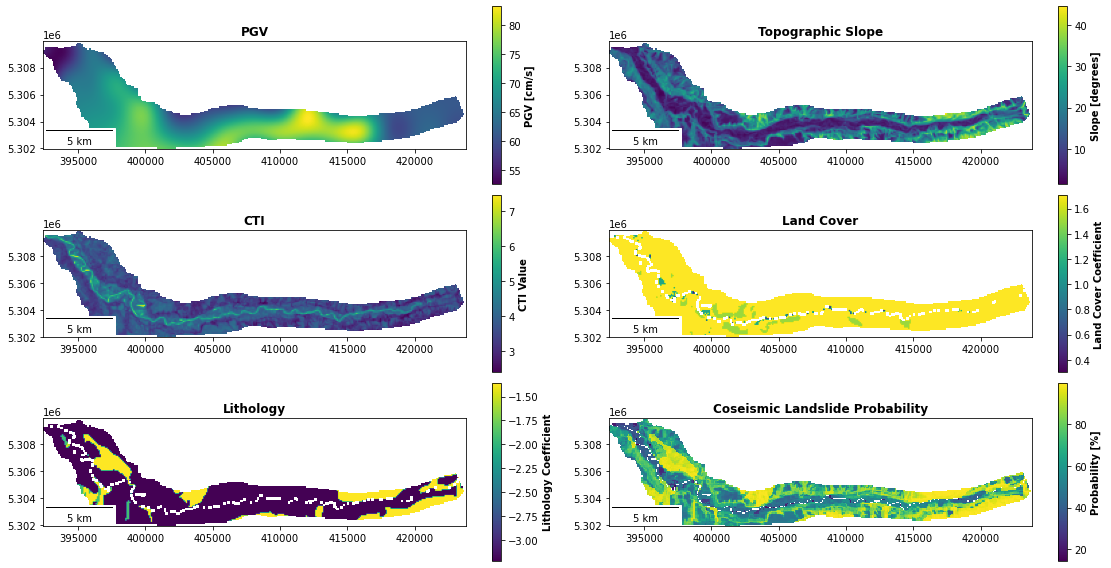

In [28]:
## Subplots
f, ax = plt.subplots(3,2, figsize=(16, 8)) #sharex=True, sharey=True)
# PGV 
pgv_plot = ax[0][0].imshow(pgv_rio_array, cmap='viridis', extent=pgv_extent);
ax[0][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][0].set_title('PGV', fontweight='bold')
pgv_cbar = f.colorbar(pgv_plot, ax=ax[0][0])
pgv_cbar.set_label('PGV [cm/s]', fontweight='bold')
# Slope
slope_plot2 = ax[0][1].imshow(slope_warp_array, cmap='viridis', extent=pgv_extent);
ax[0][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][1].set_title('Topographic Slope', fontweight='bold')
slope_cbar2 = f.colorbar(slope_plot2, ax=ax[0][1]);
slope_cbar2.set_label('Slope [degrees]', fontweight='bold')
# CTI
cti_plot2 = ax[1][0].imshow(cti_warp_array, cmap='viridis', extent=pgv_extent);
ax[1][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][0].set_title('CTI', fontweight='bold')
cti_cbar = f.colorbar(cti_plot2, ax=ax[1][0])
cti_cbar.set_label('CTI Value', fontweight='bold')
# Land Cover
lulc_plot = ax[1][1].imshow(lulc_warp_array, cmap='viridis', extent=pgv_extent);
ax[1][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][1].set_title('Land Cover', fontweight='bold')
lulc_cbar = f.colorbar(lulc_plot, ax=ax[1][1])
lulc_cbar.set_label('Land Cover Coefficient', fontweight='bold')
# Lithology
litho_plot = ax[2][0].imshow(litho_warp_array, cmap='viridis', extent=pgv_extent);
ax[2][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[2][0].set_title('Lithology', fontweight='bold')
litho_cbar = f.colorbar(litho_plot, ax=ax[2][0])
litho_cbar.set_label('Lithology Coefficient', fontweight='bold')
# Coseismic Landslide Probability
cls_plot = ax[2][1].imshow(cls_prob, extent=pgv_extent, cmap='viridis', interpolation='none');
ax[2][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[2][1].set_title('Coseismic Landslide Probability', fontweight='bold')
cls_cbar = f.colorbar(cls_plot, ax=ax[2][1])
cls_cbar.set_label('Probability [%]', fontweight='bold')

plt.tight_layout()

## Coseismic Landslide Probability for All 30 M9 CSZ Scenarios by Frankel et al. (2018)
My project synthesizes all 30 M9 CSZ scenarios by Frankel et al. (2018) to determine coseismic landslide probability in the Lower Bogachiel River Valley for multiple earthquake conditions. I created GeoTIFFs for each coseismic landslide probability map to use other tools in QGIS for further analyses.

In [29]:
# Create coseismic landslide probability maps for each M9 CSZ model
csz_model_dir = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Inputs\CSZ_M9_100m_clip'
csz_models = ['csz002', 'csz003', 'csz004', 
            'csz005', 'csz006', 'csz007', 
            'csz008', 'csz009', 'csz010', 
            'csz011', 'csz012', 'csz013', 
            'csz014', 'csz017', 'csz018', 
            'csz019', 'csz020', 'csz021', 
            'csz022', 'csz023', 'csz024', 
            'csz025', 'csz026', 'csz027', 
            'csz028', 'csz029', 'csz030', 
            'csz031', 'csz032', 'csz033']

In [30]:
# Use a For loop to create coseismic landsldie probability maps
for csz_number in csz_models:
    # Load the PGV input(s) first
    csz_pgv_input = csz_model_dir + '\\' + csz_number + '_100m_clip.tif'
    csz_pgv_rio = rio.open(csz_pgv_input)
    csz_pgv_array = csz_pgv_rio.read(1, masked=True) 
    
    # Regression coefficients for Equation 8 by Nowicki Jessee et al. (2018)
    a = -6.3
    b = 1.65
    c = 0.06
    f = 0.03
    g = 0.01
    t = a+(b*(np.ma.log(csz_pgv_array)))+(c*slope_warp_array)+litho_warp_array+lulc_warp_array+(f*cti_warp_array)+(g*(np.ma.log(csz_pgv_array))*slope_warp_array)
    # Equation 3 by Nowicki Jessee et al. (2018)
    cls_prob = (1/(1+(np.exp(-t))))*100
    
    # Create GeoTIFFs
    pgv_rio_profile = csz_pgv_rio.profile
    cls_prob_output_dir = r'C:\Users\brekc\Desktop\BRV_Nowicki_2018_Modeling\Outputs\LS_Probability_Models'
    cls_prob_tiff = cls_prob_output_dir + '\\' + csz_number + '_100m_prob.tif'
    if not os.path.exists(cls_prob_tiff):
        with rio.open(cls_prob_tiff, "w", **pgv_rio_profile) as dst:
            dst.write(cls_prob, 1)